In [32]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [33]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph 
from langgraph.graph import START, END

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage
import json

from langchain_openai import ChatOpenAI

In [59]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [60]:
######### 2. 도구 정의 및 바인딩 #########

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:     # 키워드로 뉴스 검색하는 도구     
    """Look up news by keyword"""

    news_tool = GoogleNews()        
    return news_tool.search_by_keyword(query, k=1)


tools = [search_keyword]

In [36]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [37]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")

    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [38]:
graph_builder = StateGraph(State)

In [39]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [40]:
# 도구 노드 생성
tool_node = ToolNode(tools=[search_keyword])

In [41]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [42]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [43]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [44]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [45]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [46]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [47]:
graph = graph_builder.compile(checkpointer=memory)

In [48]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

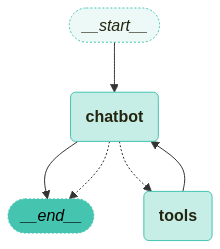

In [49]:
######### 8. 그래프 #######

visualize_graph(graph)

In [50]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": thread_id}, 
    tags=["data-tag"],                  
)

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])


i = 1

for event in graph.stream(
    input=input, 
    config=config, 
    stream_mode="values", 
    interrupt_before=["tools"]
):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)
        
        if value and "dummy_data" in value:
            print('더미 데이터: ')
            print(value["dummy_data"])
        
        if value and 'messages' in value:

            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  

thread_id: b6f316

========================= 여기서 시작 ====================
[event] 바깥 for 시작 (1)

실행한 노드 이름: messages
해당 노드 값: 

[HumanMessage(content='AI 관련 최신 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='86b62db2-7e1a-4bf1-a10f-4011bab43439')]
바깥 for 끝
========================= 여기서 끝 =========================

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='AI 관련 최신 뉴스를 알려주세요.' additional_kwargs={} response_metadata={} id='86b62db2-7e1a-4bf1-a10f-4011bab43439'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'function': {'arguments': '{"query":"AI"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_

In [51]:
snapshot = graph.get_state(config)

In [52]:
snapshot.values

{'messages': [HumanMessage(content='AI 관련 최신 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='86b62db2-7e1a-4bf1-a10f-4011bab43439'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'function': {'arguments': '{"query":"AI"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da4fd07d-40a0-40ef-9518-21551cc1e3b2-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': 'AI'}, 'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51

In [53]:
snapshot.next

('tools',)

In [54]:
existing_message = snapshot.values['messages']

In [55]:
existing_message

[HumanMessage(content='AI 관련 최신 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='86b62db2-7e1a-4bf1-a10f-4011bab43439'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'function': {'arguments': '{"query":"AI"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da4fd07d-40a0-40ef-9518-21551cc1e3b2-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': 'AI'}, 'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_toke

In [56]:
existing_message = snapshot.values['messages'][-1] 
existing_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'function': {'arguments': '{"query":"AI"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da4fd07d-40a0-40ef-9518-21551cc1e3b2-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': 'AI'}, 'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

In [57]:
display_message_tree(existing_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_rhbuj2D38nDRYIXouV77nvJR"
                function: {"arguments": "{"query":"AI"}", "name": "search_keyword"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 15
            prompt_tokens: 51
            total_tokens: 66
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_b8bc95a0ac"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-da4fd07d-40a0-40ef-9518-21551cc1e3b2-0"
    example: False
    tool_calls:
        index [0]
            name: "search_keyword"
            args: {"query": "AI"}
            id:

In [58]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

i = 1

for event in events:
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)
        
        if value and "dummy_data" in value:
            print('더미 데이터: ')
            print(value["dummy_data"])
        
        if value and 'messages' in value:

            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  


========================= 여기서 시작 ====================
[event] 바깥 for 시작 (1)

실행한 노드 이름: messages
해당 노드 값: 

[HumanMessage(content='AI 관련 최신 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='86b62db2-7e1a-4bf1-a10f-4011bab43439'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rhbuj2D38nDRYIXouV77nvJR', 'function': {'arguments': '{"query":"AI"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da4fd07d-40a0-40ef-9518-21551cc1e3b2-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': 'AI'}, 'i